In [3]:
import sys
import os
import importlib

import numpy as np
import scipy
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

import pyemma
import mdtraj as md

import extq
from extq.stop import forward_stop

In [4]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [5]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

%config InlineBackend.figure_format = "retina"

In [6]:
%load_ext autoreload
%autoreload 2

# Load data

In [7]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8] # 50 ns lag time
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[0] # 0.1 ns lag time
j_du_sb = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/j_du_sb_3.npy", allow_pickle=True)[
    6
]

In [8]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186

# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [9]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

# Committors

In [10]:
# compute E[\theta(x) S_tq_+(x)]
w_delay = [w[:-lag] for w in weights]
qp_delay = []
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

In [11]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")

In [12]:
# color arrows from transparent to white depending on magnitude
rgb = 255 / 256
colors = [(rgb, rgb, rgb, c) for c in np.linspace(0.1, 1, 100)]
cmapwhite = mpl.colors.LinearSegmentedColormap.from_list("white", colors)

In [13]:
rgb_black = 1 / 256
colors_black = [(rgb_black, rgb_black, rgb_black, c) for c in np.linspace(0.05, 1, 100)]
cmapblack = mpl.colors.LinearSegmentedColormap.from_list("black", colors_black)
mpl.colormaps.register(cmapblack, force=True)

In [12]:
def plot_current(
    cv1,
    cv2,
    j,
    weights,
    xmin,
    xmax,
    ymin,
    ymax,
    n,
    cm_j=cmapwhite,
    ax=None,
):
    xlim_flux = np.linspace(xmin, xmax, n + 1)
    ylim_flux = np.linspace(ymin, ymax, n + 1)
    centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
    centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2
    X, Y = np.meshgrid(centerx_flux, centery_flux)

    if ax is None:
        ax = plt.gca()
    # KDE bin fluxes
    jx_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 0]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )
    jy_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 1]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )

    # set color/magnitude of arrow equal to L2 norm od KDEd fluxes
    col = (jx_binned ** 2 + jy_binned ** 2) ** 0.5
    # normalize arrow so same
    quiv = ax.quiver(
        X,
        Y,
        (jx_binned / col).T,
        (jy_binned / col).T,
        col.T,
        pivot="middle",
        width=0.008,
        cmap=cm_j,
        headwidth=4,
        headlength=4,
        headaxislength=3,
        scale=15,
        scale_units="width",
        zorder=5,
    )

    return ax, quiv

/scratch/local/jobs/278587/ipykernel_861093/2130374935.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f547f618f10> has a label of '_' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=3, labels=["_", 'Down', 'Up'])
/scratch/local/jobs/278587/ipykernel_861093/2130374935.py:42: RuntimeWarning: divide by zero encountered in log
  diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol
/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


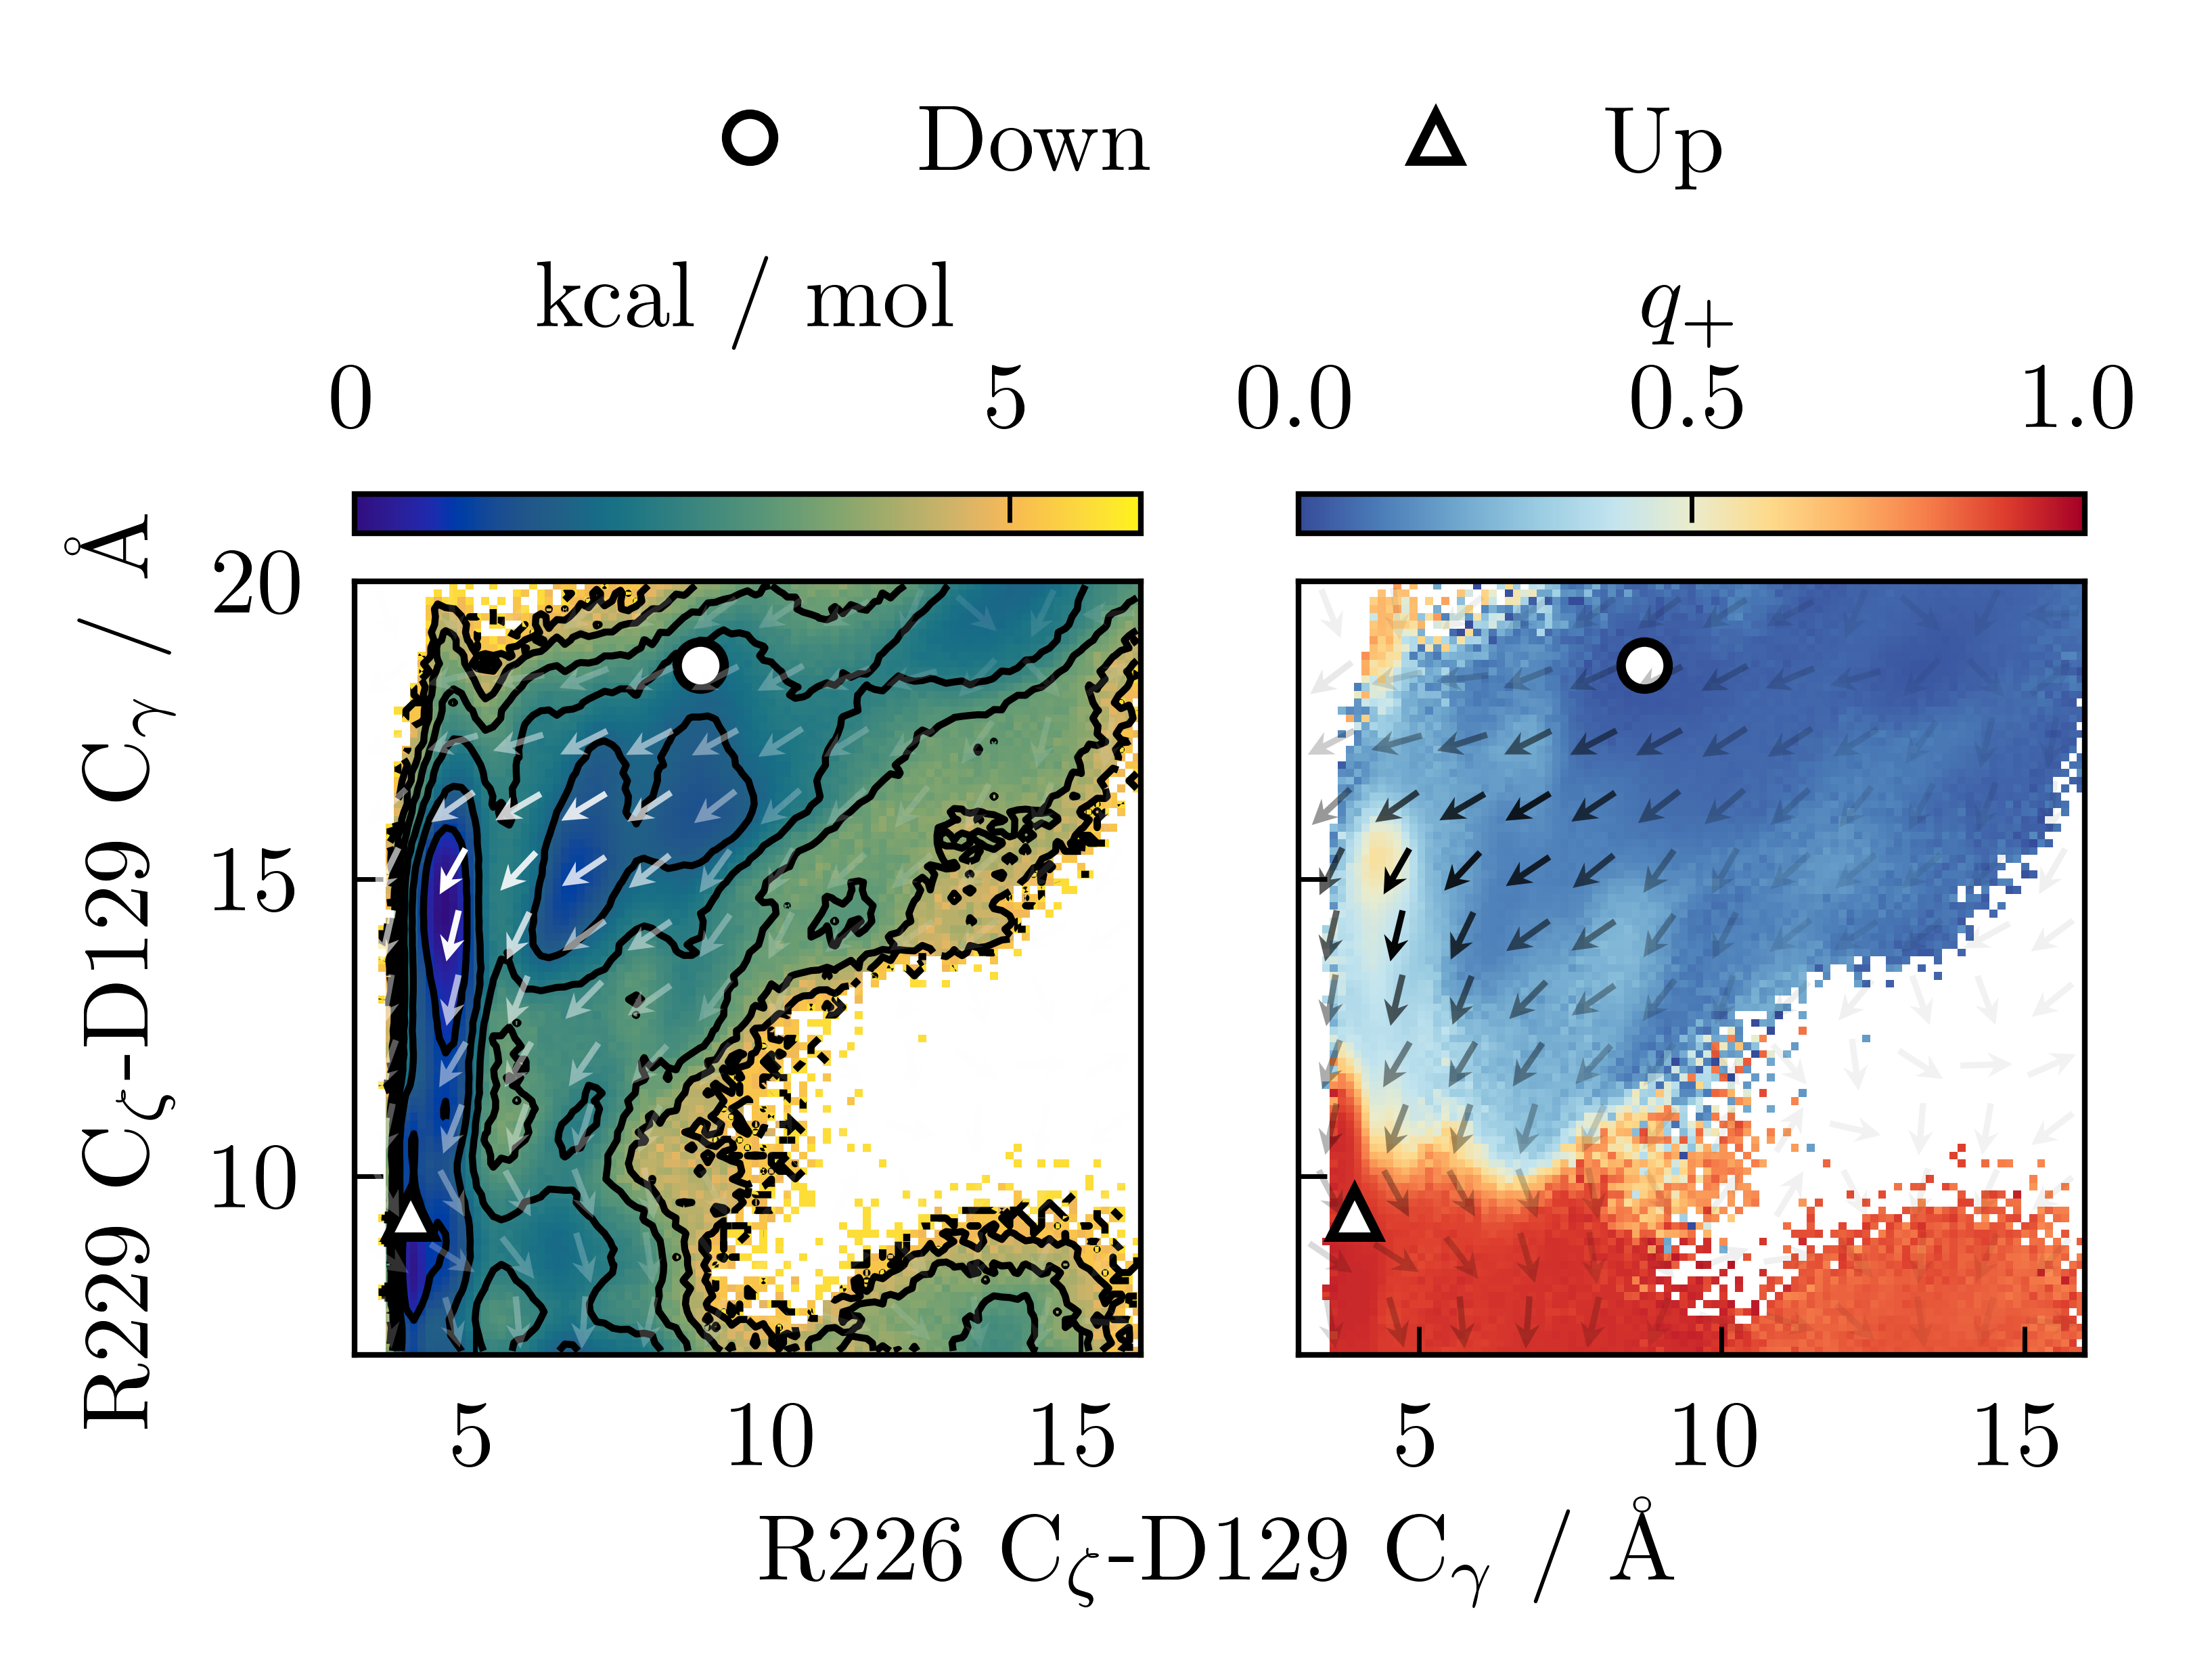

In [13]:
f = plt.figure(figsize=(3.3, 2.1), dpi=500)
ax = f.gca()

xrange = [3, 16]
yrange = [7, 20]
nbin = 100
i, j = 0, 1
sb_ids = [42, 48]
sb1, sb2 = sb_ids[i], sb_ids[j]

ax.set_xlabel(f"{sb_names[sb1]} / Å")
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
gs0 = mpl.gridspec.GridSpec(1, 2, bottom=0.2, figure=f)
ax0 = f.add_subplot(gs0[0])
ax1 = f.add_subplot(gs0[1])

sb1_lag = [t[:-lag, sb1] * 10 for t in sb_trajs]
sb2_lag = [t[:-lag, sb2] * 10 for t in sb_trajs]
xlim = np.linspace(*xrange, nbin)
ylim = np.linspace(*yrange, nbin)
xc = (xlim[1:] + xlim[:-1]) / 2
yc = (ylim[1:] + ylim[:-1]) / 2

sb0_trajs = [t[:, sb1] * 10 for t in sb_trajs]  # in Angstroms
sb1_trajs = [t[:, sb2] * 10 for t in sb_trajs]

for ax in (ax0, ax1):
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=5, zorder=5)
    ax.set(
        ylabel=f"{sb_names[sb2]} / Å",
    )
    ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)
    ax.label_outer()
f.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=3, labels=["_", 'Down', 'Up'])

# PMF (left)
pmf = extq.projection.density2d(sb0_trajs, sb1_trajs, weights, xlim, ylim)
offset = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol
h = ax0.pcolormesh(xc, yc, diff.T, cmap='macaw', vmin=0, vmax=6, rasterized=True)
ax0.contour(xc, yc, diff.T, colors="black")
ax0, quiv = plot_current(
    sb0_trajs,
    sb1_trajs,
    j_du_sb[:, [i, j]],
    weights,
    *xrange,
    *yrange,
    12,
    ax=ax0,
    cm_j=cmapwhite,
)
cb = plt.colorbar(h, ax=ax0, orientation='horizontal', location='top')
cb.set_label("kcal / mol")

# Committor
q_dens = extq.projection.average2d(sb1_lag, sb2_lag, qp_delay, w_delay, xlim, ylim)
hq = ax1.pcolormesh(xc, yc, q_dens.T, cmap=cm_div, vmin=0, vmax=1, rasterized=True)
ax1, quiv = plot_current(
    sb0_trajs,
    sb1_trajs,
    j_du_sb[:, [i, j]],
    weights,
    *xrange,
    *yrange,
    12,
    ax=ax1,
    cm_j="black",
)
cb = plt.colorbar(hq, ax=ax1, orientation='horizontal', location='top')
cb.set_label("$q_+$")
# plt.savefig("../figures/fig3_sb.pdf", pad_inches=1.0)
plt.savefig("../../fig/paper/fig3_sb.pdf", bbox_inches='tight')

# Violin plots

In [14]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

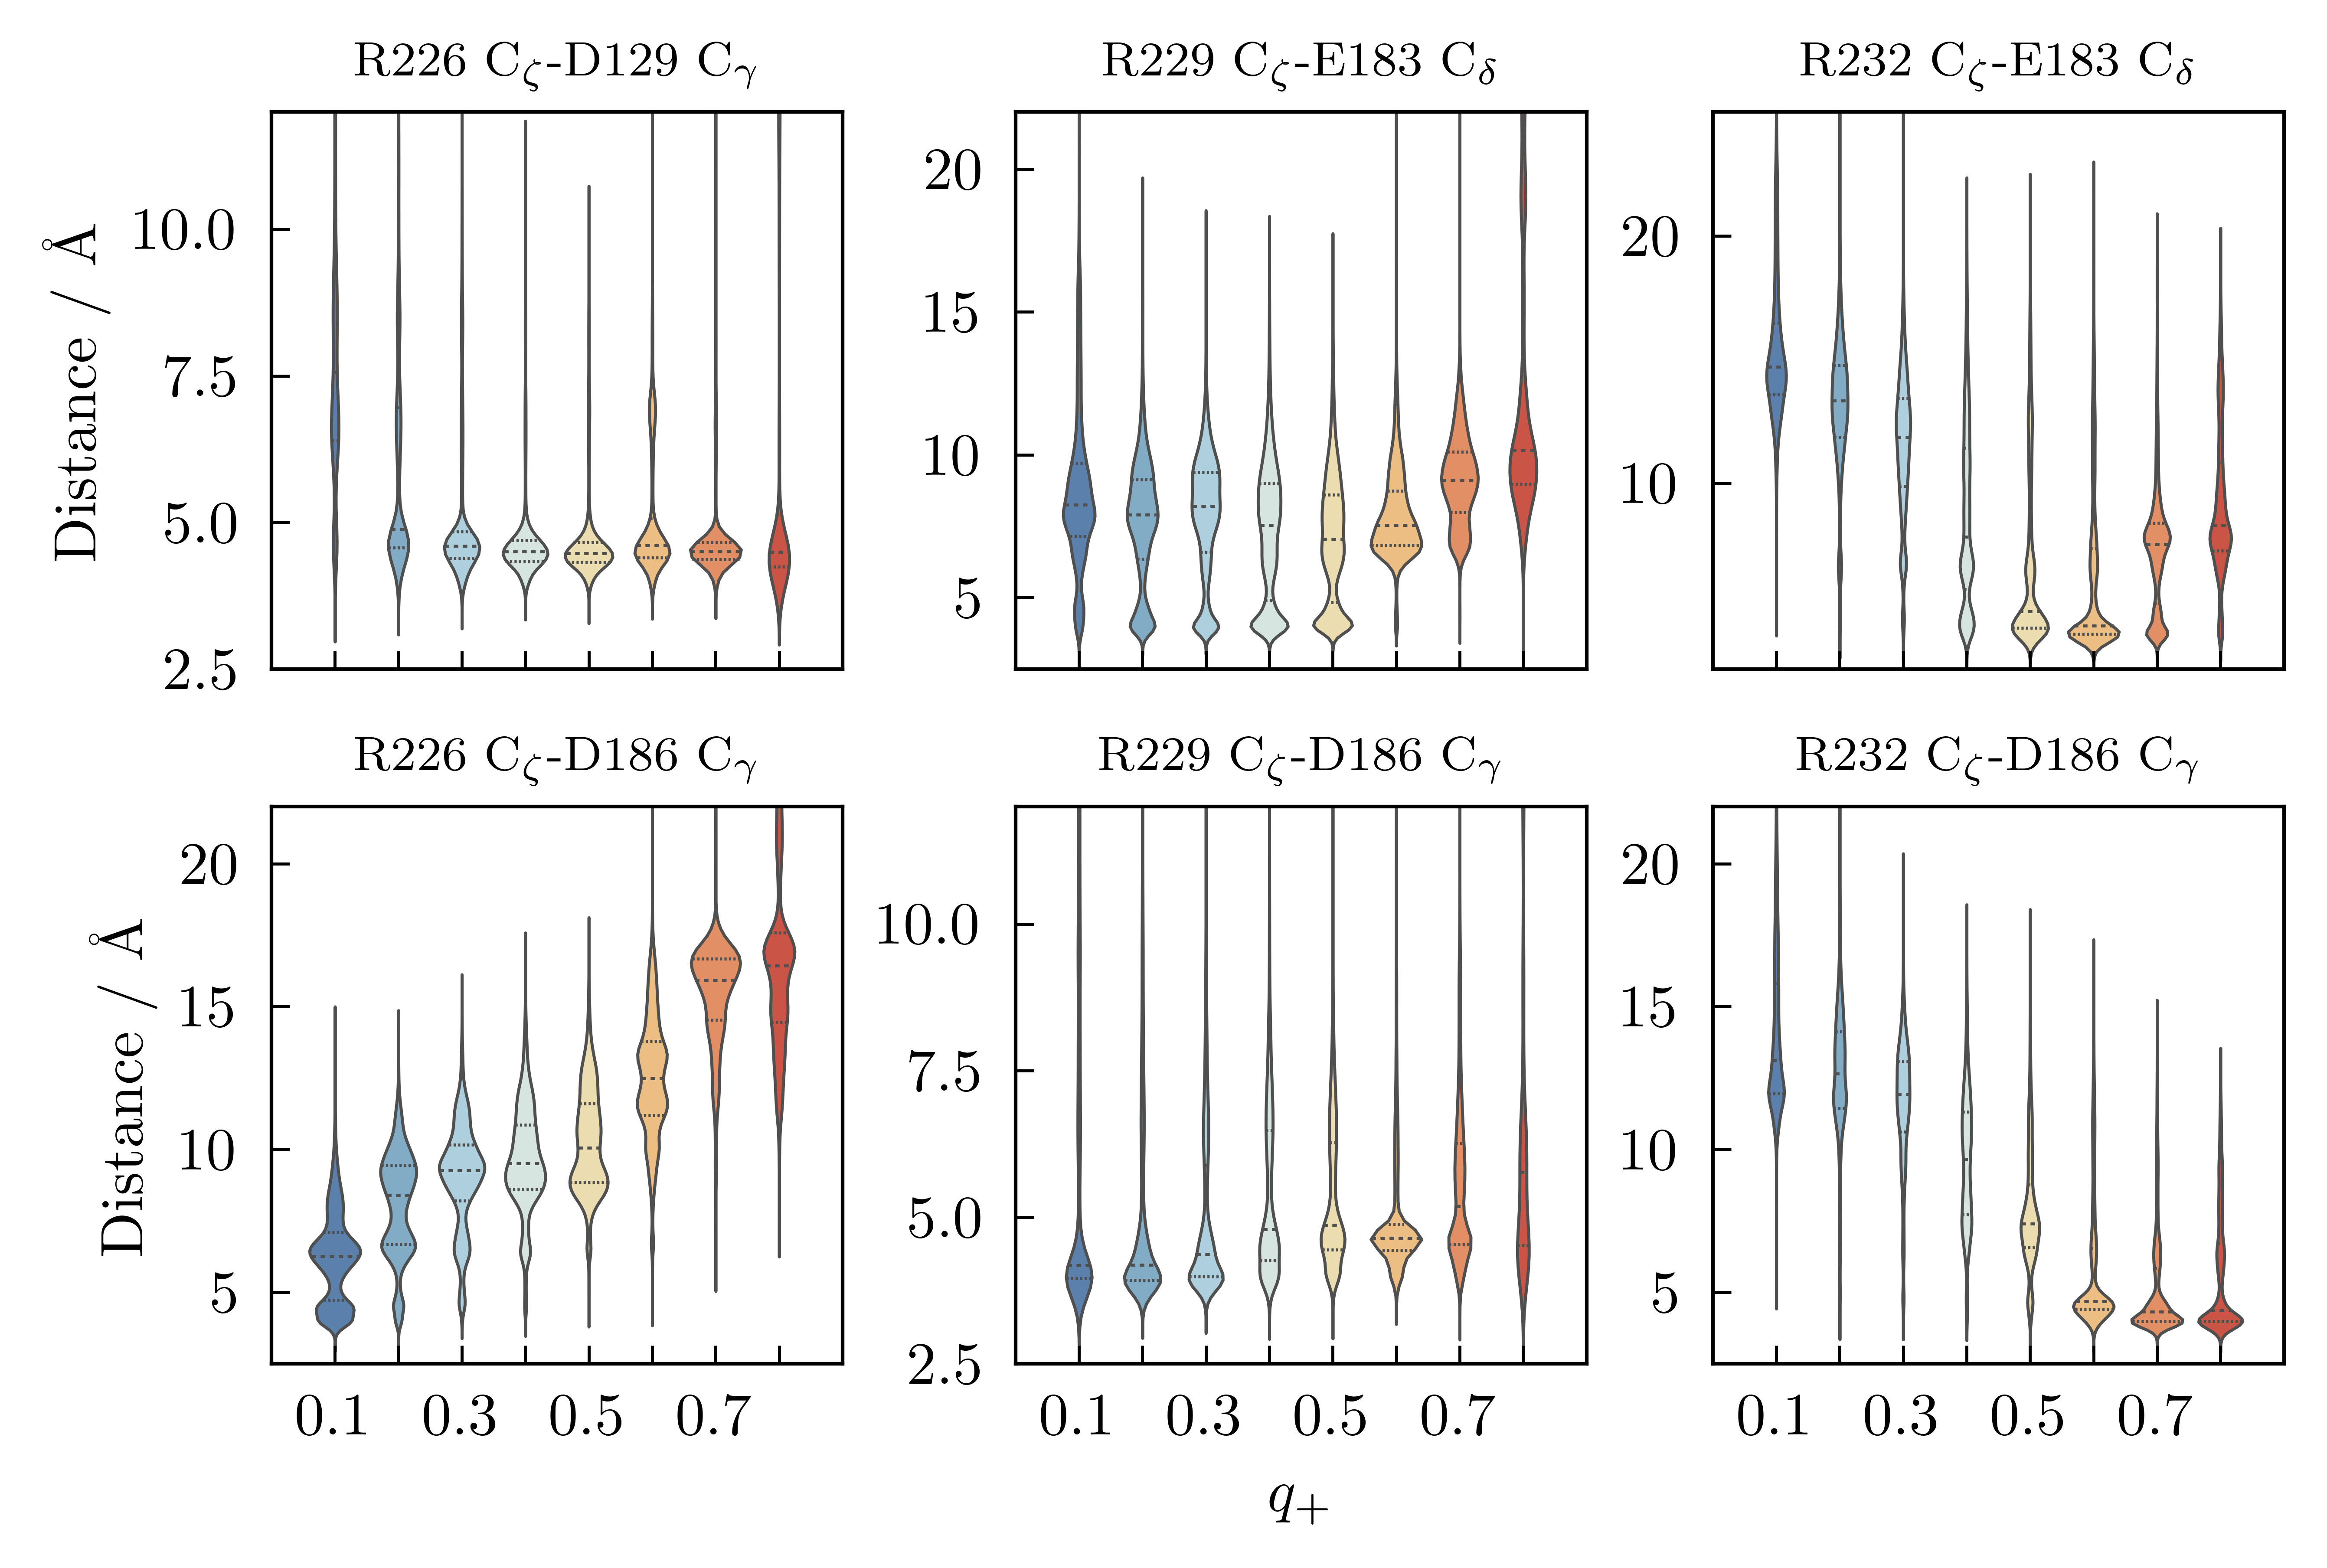

In [20]:
steps, q_inds = bin_inds(qp_du, qstep=0.1, low=0.05, hi=0.85)

steplabels = []
for i, s in enumerate(steps):
    if i % 2 == 0:
        steplabels.append(f"{s+0.05:.1f}")
    else:
        steplabels.append("")

f, axs = plt.subplots(
    2, 3, figsize=(5.25, 3.5), dpi=500, sharex=True, constrained_layout=True
)

# sb_ids = [42, 47, 52, 53, 58, 59]
# xmax = [12, 22, 22, 12, 25, 22]
sb_ids = [42, 52, 58, 47, 53, 59]
xmax = [12, 22, 25, 22, 12, 22]
for i, ax, xhi in zip(sb_ids, axs.flat, xmax):
    sns.violinplot(
        ax=ax,
        data=[sb_arr[inds, i] * 10 for inds in q_inds],
        orient="v",
        scale="area",
        bw=0.1,
        inner="quartile",
        palette="diverging",
        linewidth=0.5,
    )
    # ax.set_xlabel(f"{sb_names[i]} / Å")
    ax.set_title(f"{sb_names[i]}", fontsize=8)
    ax.set_xticklabels(steplabels)
    ax.set_ylim([2.5, xhi])
    ax.set_xlim([-1, 8])
    # ax.invert_yaxis()
axs[0, 0].set_ylabel("Distance / Å")
axs[1, 0].set_ylabel("Distance / Å")
axs[1, 1].set_xlabel("$q_+$")
plt.savefig("../../fig/paper/sb_violins.pdf", bbox_inches='tight')